**1. Colab 환경설정**

In [35]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install konlpy
!pip install torch
!pip install ipywidgets  # for vscode
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-aubejbu4
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-aubejb

In [36]:
import torch
#gpu 사용시에만 적용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#GPU 사용
device = torch.device("cuda:0")

Sun Jun 19 07:09:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    36W / 250W |  13769MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
#RAM 셋팅
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [38]:
import pandas as pd
import konlpy
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [40]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

2. 데이터셋 전처리

In [41]:
data = pd.read_excel('/content/drive/MyDrive/ABP_data.xlsx')

In [42]:
# 2017년 7월 1일 지식제안 체계 개편
from datetime import datetime as dt
data["심의요청일"] = pd.to_datetime(data["심의요청일"], format="%Y/%m/%d")
data["심의완료일"] = pd.to_datetime(data["심의완료일"], format="%Y/%m/%d")
data = data.loc[data["심의요청일"] >= dt(2017, 7, 1)]   

In [43]:
# 지식제안 데이터만 사용
data = data.dropna(subset=['제안구분'])
data = data.loc[data["제안상태"].isin(["불채택", "개발완료", "채택", "개발중"])] 
# 카테고리 3 Depth 만 사용
data = data.loc[data["제안구분길이"] == 3]
# 중복인 경우 최신 데이터만 남기기
data = data.dropna(subset = ['제안명','현황 및 문제점', '개선방안 및 기대효과'])
data = data.sort_values(by=["심의요청일", "현황 및 문제점"])
data = data.drop_duplicates("제안명", keep="last")
data = pd.DataFrame(data)
# 데이터 집계1 - 카테고리별 건수 
print(data.shape)
count_category = pd.DataFrame(data.groupby('심의부서')['제안명'].count())

(20850, 27)


In [44]:
df = pd.DataFrame(data)
df.head(10)

,OID,구분,세부구분,제안번호,키워드,카테고리ID,제안구분,제안명,제안부서,제안자명,...,현황 및 문제점,개선방안 및 기대효과,반송코드,반송사유,기제안번호,심의내용,COLLABORATOR,AI식별자,AI카테고리순위,제안구분길이
37290,3170703145615198754,제안,지식제안,2017-03886,"국민ONE통장,가계부",148.0,수신>수신상품부>요구불예금,국민 ONE통장 입출금거래내역 표시건 표시 수정요청건,효창동지점,박주광,...,,매월 1일에 가계부 기능으로 금액이 표시되는데. 얼핏 보기엔 거래내역이 연속된 ...,반송 11-3,이미 부서에서 검토하였으나 실효성이 낮아 종결한 사항,NaN,바쁘신 와중에 소중한 지식제안 감사드립니다. 가계부기능 통장 인자에 대한 의견...,NaN,NaN,NaN,3
37316,3170703183532057434,제안,지식제안,2017-03914,"태블릿브랜치,신분증 진위확인",437.0,영업지원/기타>아웃바운드지원부>KB태블릿브랜치(시스템운영),태블릿브랜치 신분증 진위확인 처리방법 개선,진천지점,신우관,...,"- 태블릿브랜치에서 신분증 진위확인시 주민등록증은 1382, 운전면허증은 인...",- 창구직원 신분증 진위확인 시스템과 동일하게 신분증 진위확인 버튼 클릭하면 자...,반송 11-7,IT구현 등 기술적 제약 존재,NaN,"태블릿브랜치 업무에 관심을 가져 주셔서 감사합니다. 제안해주신 ""신분증 ...",NaN,NaN,NaN,3
37313,3170703181130026414,제안,지식제안,2017-03912,"자동화기기 미수취,미수취",380.0,영업지원/기타>채널지원부>무인채널 전략수립 (ATM 전략 및 수수료/자동화기기이용번...,자동화기기 미수취 발생시 처리방법 개선자동화기기,진천지점,신우관,...,* 현황 - 자동화기기에서 현금 및 수표 출금시 고객께서 휴대폰 조작...,* 개선방안 - 고객 미수취 발생시 현금 출금시 출금금액을 계수하여 회수하...,반송 11-2,이미 개발 진행 중이거나 시행 중인 것,NaN,귀하의 제안에 감사드립니다.자동화기기의 미수취 장애 발생 시 입금 처리 방법 개...,NaN,NaN,NaN,3
37322,3170703190626760232,제안,지식제안,2017-03920,"자동이체,자동이체 미처리",149.0,수신>수신상품부>자동이체(계좌간/타행/납부자/아파트관리비/선일자),자동이체 미처리시 고객앞 sms발송,동대문패션타운지점,양이지,...,&lt;현황 자동이체 신청건 미이체시 고객에 ' 자동이체가 미처리되었습니다...,&lt;개선방안 및 기대효과 문자발송시 출금계좌번호와 더불어 어떠한건이 미처...,반송 11-2,이미 개발 진행 중이거나 시행 중인 것,NaN,바쁘신 업무중에도 지식제안에 감사드립니다. 현재 자동이체 업무에서 타행자동이체인...,NaN,NaN,NaN,3
37332,3170703212225305192,제안,지식제안,2017-03930,"상담담보평가,면적",251.0,여신>여신코어뱅킹부(P)>여신담보(IT),상담담보평가(11-3F-014) 화면 '우선변제/임금채권' 탭에 면적 입력시 소숫점...,병점중앙지점,이주철,...,&lt;현황 1. 상담담보평가(11-3F-014) 화면의 '우선변제/임금채권...,&lt;개선방안 1. '우선변제/임금채권' 탭에서 면적 입력시 마지막 두 자...,NaN,NaN,NaN,여신담보업무 개선에 관심을 가져주셔서 감사합니다. 다른 화면에서 면적입력...,NaN,NaN,NaN,3
37333,3170703213218821974,제안,지식제안,2017-03931,"면적,우선변제보증금",236.0,여신>기업상품부>담보평가(기업),면적단위 표기,병점중앙지점,이주철,...,&lt;현황 상담담보평가(11-3F-014)의 '우선변제/임금채권' 탭에 면...,&lt;개선방안 면적 입력란 옆(오른쪽)에 '평방미터' 심볼 표기 (참고:...,NaN,NaN,NaN,담보평가 업무에 보내주신 관심과 제안에 감사드립니다. 제안자께서 제안하신 내용...,NaN,NaN,NaN,3
37274,3170703112906540679,제안,지식제안,2017-03868,"담당자,전화번호",409.0,영업지원/기타>혁신추진부>프로세스 개선,마이스타 단말 거래시 해당 업무 화면에서 담당자 조회,죽전역지점,신기욱,...,*현황: 마이스타단말에서 업무시 해당업무의 본부부서 담당자와 통화를 해야 할 ...,*개선방안 :단말 거래시 해당 문서나 장표를 연결해서 볼 수 있는 현 시스템처럼...,반송 11-4,과거 1년간 이미 접수된 제안과 동일,NaN,★반송사유 : 반송 11-3:심의요청일로부터 과거 1년간 이미 접수된 제안과 동...,NaN,NaN,NaN,3
37246,3170703093229941507,제안,지식제안,2017-03836,"외화,매입,수수료,감면",428.0,"외환>외환마케팅부>무역 상품(서비스), 무역 비대면 채널",외화현찰 매입 시 현찰수수료감면구분 전산 개선의 건,포항종합금융센터,권현진,...,- 00-41-002 외국통화매입 전산에서 수수료감면구분 1-본부승인 선택 살행...,1- 수수료 감면 남용 방지 2- 고객 응대 일관성 유지 가능 (A지점에선 감...,반송 11-2,이미 개발 진행 중이거나 시행 중인 것,NaN,"바쁜 업무중에도 외환업무에 관심을 가져주셔서 감사합니다. 말씀하신 거래 시, ...",NaN,NaN,NaN,3
37325,3170703191704233001,제안,지식제안,2017-03924,"기업여신,cif,고객종합정보조회,채권서류,서류편철",203.0,여신>기업상품부>SOHO여신프로세스,"기표 전, 후 고객정보조회(CIF), 신용정보조회, 여신원장조회 일괄조회할 수 있는...",상무지점,김형균,...,"- SOHO 및 법인여신심사 프로세스에서 심사 시점, 그리고 기표 당시 고객의 ...",- 현재 여신승인이 완료되면 보고서리스트를 일괄출력하여 채권철에 편철할 수 있듯...,반송 11-2,이미 개발 진행 중이거나 시행 중인 것,NaN,"바쁘신 중 기업여신프로세스 관련 제안에 감사드리며, 심의가 지연된점 양해말씀 드...",NaN,NaN,NaN,3
37262,3170703104938011821,제안,지식제안,2017-03853,"여신심사,보고서 업무",244.0,여신>여신코어뱅킹부(P)>기업심사승인(IT),소호심사 보고서리스트(04-3B-048)에서 보고서 출력 관련,가경동지점,모경호,...,- 소호심사 보고서리스트(04-3B-048) 화면에서 출력할 보고서를 선택후 출...,- 내가 필요한 보고서를 선택했음에도 출력시 건건이 다시 클릭해서 출력해야 하는...,반송 11-7,IT구현 등 기술적 제약 존재,NaN,기 영업점 요청사항입니다. 그러나 보고서를 출력하는 Tool 에 제약조건이 ...,NaN,NaN,NaN,3


In [45]:
df.drop(df.loc[df['제안구분']=='수신>수신상품부>계산'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>신탁대출'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>특정금전신탁(MMT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>대손상각'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>여신사후관리(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>통신, 인터폰(자동화기기)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금컨설팅부>퇴직연금 연금계리, 재정검증 등'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신상품부>내국환'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>여신금리(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>B2B(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>브랜드전략부>상품광고'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(의료비,근무복)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부(퇴직연금지원Unit)>퇴직연금 후선업무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>공과금/공금예금'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>주택기금부>국민주택채권'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>리스크관리부>리스크자가진단 (CSA)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>브랜드전략부>KBN위성방송'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>안전관리부>CCTV운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(장례지원)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>시설관리(건축)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>카드금융부>현금서비스(CA)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>전략기획부>직제'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>동산관리(사무/공조기기)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금컨설팅부>퇴직연금 세무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업경영개선부>기업워크아웃'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>자산건전성 및 연체관리 기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기업신용평가(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>주택기금부>기금사후관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>개인마케팅부(마케팅1부)>통장디자인'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>국군마케팅부>군부대/나라사랑카드'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>법률지원부>법무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>여신거래한도'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금세탁방지부>RBA (자금세탁위험평가)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>재무기획부>예산'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>전략기획부>전략기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>중소기업고객부>기업영업추진'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>법원문서'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>시설관리(기계설비)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>평가제도개선'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM기획부>자산현황통보'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>총무지원부>카드 교부/자재 관리/실물 발행'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>이자계산'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>경영정보공통'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>기관영업부(P)>지자체/정부'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>리스크관리부>운영리스크 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>연수기획/제도운영,KPI/국내외MBA'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>정보보안부(P)>IT보안(인터넷보안)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>동산관리(비품관리)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>시설관리(CI/간판)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>ESG기획부>ESG 및 CSR'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM기획부>복합점포 시너지'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM투자전략부>사후관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>여신코어뱅킹부(P)>전자무역/SWIFT(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>개인회원 통합/Mass 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>체크카드사업부>체크카드 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>회원영업부>비대면(온라인,모바일) 카드 모집/마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>적립식(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기한연장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담부>업무상담(4119상담)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>산업정보조회시스템'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>아웃바운드지원부>대출상담사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>영업기획부>영업기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금운용지원부>지준이체'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자본시장영업1부>골드통장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널감사부>영업채널감사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>자산관리/종합물자'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>개인평가'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>인사기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>여신코어뱅킹부(P)>수입(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>외환마케팅부>외국인마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>우수고객 제도 운영 및 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객서비스부>고객센터 상담/교육'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부(연금상품운영Unit)>퇴직연금 고객 및 수익률 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>가수/가지급, 수입인지/증지'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>데이터분석부(P)>신용정보(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>여신계정등록/변경'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>데이터분석부(P)>민원(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담플랫폼부(P)>인바운드(화면개발 및 수정)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>경영자예비과정/글로벌인력양성'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>정보보안부(P)>전자금융보안'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(건강검진)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>구매관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>테크기획부>채용'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>DT전략부>혁신서비스'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>이동 및 공모'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM투자자문부>전문가상담예약서비스 기획 및 운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>여신코어뱅킹부(P)>외환공통(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>업무혁신부>체크카드 제도 기획 및 운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부>연금사업 기획(사업전략, KPI, 교육/연수 등)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>원천징수, 중요증서'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업금융솔루션부(P)(솔루션1부(상품))>공급망금융'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업금융솔루션부(P)(솔루션1부(상품))>비대면 기업 대출'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>여신사후관리 SMS,DM'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>성과관리(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>글로벌지원부>해외사업'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>기관영업부(P)>공공기관'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담플랫폼부(P)>아웃바운드(화면개발 및 수정)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>담보회수율'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>Total Exposure'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>아웃바운드지원부>집단대출'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>리더십/신임ㆍ승격예비과정/팀빌딩'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>동산관리(비품배정)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>부동산관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>시설관리(365자동화)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>겸업/겸직'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>계약직원 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>채용'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>휴직/복직 및 퇴직'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>우수고객 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>브랜드전략부>광고'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>금융공동망'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>판매대행'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>수신코어뱅킹부(P)>신탁(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>부동산맞춤신탁'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>특정금전신탁(CP)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기술금융부>기술평가'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업경영개선부>기업회생'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업상품부>SOHO 신상품'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>데이터분석부(P)>여신 상품/금리정보'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>신용정보사 채권 회수위임'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>채무조정(가계NPL)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>채무조정(기업NPL)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>대외기관제공정보등록'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>리스크관리부>주요위험지표(KRI)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>본점감사부>본부감사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용감리부>신용감리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>재무기획부>자본금/공시'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>증권대행부>증권대행'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(퇴직직원)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널지원부>영업점 디자인 표준메뉴얼'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>테크기획부>IT감사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>ALM부>자금관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>ALM부>자산부채관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>여신코어뱅킹부(P)>수출(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>굿세이브서비스'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>소비자보호부>소비자보호/CS(고객만족)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>업무혁신부>결제계좌/결제일/사용등록'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>영업기획부>대고객 메시지(SMS/이메일/PUSH 등)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금운용지원부>지준이체'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기한연장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담부>업무상담(4119상담)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>적립식(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>개인회원 통합/Mass 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자본시장영업1부>골드통장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널감사부>영업채널감사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>영업기획부>영업기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>산업정보조회시스템'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>영업기획부>대고객 메시지(SMS/이메일/PUSH 등)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금운용지원부>지준이체'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기한연장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담부>업무상담(4119상담)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>적립식(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>체크카드사업부>체크카드 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>회원영업부>비대면(온라인,모바일) 카드 모집/마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>KB부동산플랫폼부(P)>아파트시세, 주택통계'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(콘도)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>신용평가모델부>개인신용평가모델(가계용)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>스터디그룹/상시학습프로그램/자기주도학습비'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>법적절차'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>브랜드전략부>디자인(카드 디자인 등)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기업심사승인(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>카드금융부>카드론'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>특수채권'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>주택기금부>기금구입자금'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>공통(000과목)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>보증'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>여신신규/여신조회'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>체크카드사업부>체크카드 상품 개발 및 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>아웃바운드지원부>Out Bound 마케팅 영업점 코칭 프로그램 운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>소비자보호부>고객경험관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>개인워크아웃(개인회생/신용회복/개인파산)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널감사부>RAS 전산평가'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>상품기획부>개인범용카드 신상품 개발/제안'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업상품부>여신전결'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>직무사무분담'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>인장관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>거치식(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>개인협약대출,개인보증부대출'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>상벌'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>회계부>세무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='고객정보>데이터분석부(P)>고객정보(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>신용평가모델부>개인신용평가모델(소매형소호)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>신탁 신상품'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>FI영업부>해외직접투자/FDI'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>사용자권한관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='펀드/방카>금융투자상품본부(방카Unit)>방카슈랑스상품'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>스마트상담부(대전상담팀)>단기연체독촉 및 만기안내'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>동산관리(차량)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>입금상환'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>전략기획부>KB금융 시너지 강화방안'].index, inplace=True)

In [46]:
print(df['제안구분'].value_counts())

여신>개인여신부>가계여신일반운용제도                         1294
수신>수신상품부>수신 신규/해지/제신고/제증명                    879
수신>수신상품부>요구불예금                               761
영업지원/기타>영업플랫폼부(P)>디지털창구업무                    699
퇴직연금>연금기획부>퇴직연금 업무 프로세스 관리 및 개선              682
                                            ... 
카드>신용기획부>회원 자격/심사 기준                          10
영업지원/기타>WM기획부>PB(Private Banking)기획 및 운영      10
영업지원/기타>신용리스크부>Sub-Limit                      10
카드>정보보호부>정보보호                                 10
퇴직연금>연금기획부>퇴직연금 비대면(스타뱅킹, 인터넷뱅킹)              10
Name: 제안구분, Length: 190, dtype: int64


In [47]:
#제안명에서 키워드가 분류되므로, 키워드 삭제
#제안구분에는 부서명이 들어가므로, 심의부서만 확인
#총제안 = 제안명, 현황 및 문제점, 개선방안 및 기대효과 취합하였으나 현황 및 문제점 제거하고 제안명, 개선방향 및 기대효과만 보는 방향으로 전환
df = df[['제안명', '개선방안 및 기대효과', '제안구분']]
df["총제안"] = df["제안명"] + " " + df["개선방안 및 기대효과"]
import re
def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

df['총제안'] = df['총제안'].apply(lambda x:extract_word(x))
df = df[['총제안', '제안구분']]
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,총제안,제안구분
37290,국민 통장 입출금거래내역 표시건 표시 수정요청건 매월 일에 가계부 기능으...,수신>수신상품부>요구불예금
37316,태블릿브랜치 신분증 진위확인 처리방법 개선 창구직원 신분증 진위확인 시스템과...,영업지원/기타>아웃바운드지원부>KB태블릿브랜치(시스템운영)
37313,자동화기기 미수취 발생시 처리방법 개선자동화기기 개선방안 고객 미...,영업지원/기타>채널지원부>무인채널 전략수립 (ATM 전략 및 수수료/자동화기기이용번...
37322,자동이체 미처리시 고객앞 발송 개선방안 및 기대효과 문자발송시 ...,수신>수신상품부>자동이체(계좌간/타행/납부자/아파트관리비/선일자)
37332,상담담보평가 화면 우선변제 임금채권 탭에 면적 입력시 소숫점...,여신>여신코어뱅킹부(P)>여신담보(IT)
...,...,...
59279,가계대출상품설명서 서식 개정 고객 자필 기재 내용을 좀 더 진하게 표시하고...,여신>개인여신부>가계여신일반운용제도
59290,원스탑 신규시 전자금융 장애 관련 뱅킹 연동 신규시 통장 미발행 여부 체크를 실...,수신>영업플랫폼부(P)>One-Stop 신규
59291,고객업무처리중 고객의 착오작성시 다시쓰기 기능을 창구직원단말기에도 생성토록 ...,영업지원/기타>영업플랫폼부(P)>디지털창구업무
59304,활용을 통한 근저당설정 이행등록 절차 간소화 개선방안 활용...,여신>개인여신부>담보관리(가계)


In [48]:
df['총제안'] = df['총제안'].str.strip()
df['총제안'] = df['총제안'].map(lambda x: ' '.join(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
# LabelEncoder 함수를 이용해 각 심의부서 텍스트를 숫자로 라벨링
import numpy as np
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['제안구분'] = le.fit_transform(df['제안구분'])
df.head(10)
df_list = df['총제안'].values.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [50]:
df['제안구분'].unique()

array([ 15,  99, 129,  16,  75,  59, 136, 139,  53,  68,  54,  69, 124,
        35,  72, 164, 120, 132, 106, 151,  64, 159,  40, 186,  17,  44,
        63,  11,   3, 140,  48,  87,  23,  19, 109, 114,  65, 170,  86,
       187, 160,   5, 184, 130, 169,  13,  60,  57, 146,  71,  83,  27,
        25,   2, 138, 183,  81, 172,  84, 157, 173, 116,  14,  21, 101,
       133, 167,  26,  31, 149, 188,   7,  29,  30,  43, 103, 121, 155,
       142,  28,  96,  74, 113, 148, 185,  41,  38,  36, 163, 105, 131,
       128,  52,  10,  66,  33,  32,   1, 143,  51,  80, 135,  82, 123,
        67,  90,  39,  78, 178,  70, 145,  56,   6,  79, 176,  18,  12,
        89,   9, 144, 127,  77,  85,  34,  97,  55,  37,  49,   8, 141,
       112, 174, 177, 134, 168, 156, 189,  93, 166,  22, 171, 162, 137,
        42,  94,   4, 126, 107, 100,  61,  98,  76,  73, 104, 152,   0,
        62,  88, 125,  47,  24,  58,  92, 102,  45,  46, 108,  95, 153,
       122,  50, 147, 165, 117, 115, 119, 179, 175, 150, 118, 18

In [51]:
df_list[53]

'연속거래에 따른 스캔 신분증 재사용 범위 문서화지점에서 이에 프로세스혁신부에 제안 드립니다 각 업무별로 실명증표에 대한 명확한 지침을 내려주시기 바랍니다 실명증표의 범위 스캔신분증 사용 범위 가능업무 등 지점에서 논쟁이 되는 업무를 각 업무별로 한장의 문서나 지침으로 명문화하여 지점 창구직원이나 자점감사 전산감사 경영감사 등 모든 업무의 지침으로 만들었으면 좋겠습니다'

제안의 최대 길이 : 2196
제안의 평균 길이 : 160.35459747038746


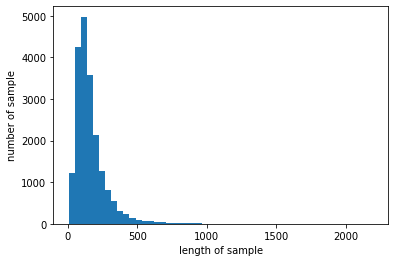

In [52]:
#제안 길이수 확인
print('제안의 최대 길이 :',max(len(review) for review in df_list))
print('제안의 평균 길이 :',sum(map(len, df_list))/len(df_list))
plt.hist([len(s) for s in df_list], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [53]:
#전체 제안 중 길이 비율 확인
def below_threshold_len(max_length, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_length):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_length, (count / len(nested_list))*100))

max_length = 256
below_threshold_len(max_length, df_list)

전체 샘플 중 길이가 256 이하인 샘플의 비율: 86.24272234491066


In [54]:
#train/test를 위핼 리스트형식으로 변환
data_list = []
for q, label in zip(df_list, df['제안구분'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)
print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[18000])
print(data_list[-1])

['국민 통장 입출금거래내역 표시건 표시 수정요청건 매월 일에 가계부 기능으로 금액이 표시되는데 얼핏 보기엔 거래내역이 연속된 것처럼 보여서 고객이 입금 출금의 착오가 있다고 확인해 달라고 하는 사례가 발생 되고 있습니다 가계부 내용을 표시하기전에 전자금융 이만영 농협 가계부기능 전월 총 입금건수 건 입급금액 원 전월 총 출금건수 건 출금금액 원 전월 총 수수료면제건수 건 면제금액 원 날짜 대신에 가계부기능 이라고 넣어 주는 표기 방법과 한줄의 선을 그어서 입 출금과 내용구분이 필요할 것 같습니다 고객님이 입출금 내용에 대한 혼동으로 창구에 와서 입 출금 내역이 잘못 되었다고 하며 재확인을 해달라는 불필요한 시간을 없앨 수 있고 입 출금 잘못된게 아닌가 하는 걱정과 혼동을 줄일 수 있어 거래내역에 대한 신뢰도를 높일 수 있음', '15']
['공무원우대대출 영업점장우대금리 적용반영되는 세부우대항목 조회 가능하도록 전산개발 공무원우대대출 계좌적용이율조회시 영업점장 우대금리가 어떻게 우대되고 있는지 항목별로 우량등금우대금리 몇 거래실적우대금리 항목별로 어떤것이 몇 반영되어 있는지 전산조회해서 알 수 있도록 전산개발 되었으면 합니다 개선후 대고객 서비스 만족개선 및 창구업무 효율성이 크게 증진 될 것으로 예상됩니다', '38']
['대출 자동연장 문자 발송시 날짜가 내용에 없습니다 발송 내용에 언제부터 스타뱅킹이나 리브똑독이나 유선으로 가능합니다 문구가 필요합니다 사전 안내 문자 입니다 년 월 일 부터 아래 방법으로 진행하시면 됩니다 문구가 처음에 있으면 긴 문자를 읽어 보지 않고 아 하고 고객님이 인지 하기가 쉽겠습니다', '40']
['전자금융 발급 재발급 시 수수료 출금계좌 연동 작성 기능 개선방안 단말 전산에서 수수료 출금 계좌를 입력하면 디지털 화면에서 연동되어 고객확인 후 인감날인이나 서명을 바로 할 수 있도록 함 고객확인 란을 따로 표시해 두었으면 함 예시 수수료 출금계좌 확인 기대효과 빠른 업무처리와 감사 지적 줄이는 효과', '162']
['당첨된 

In [55]:
#train & test 데이터로 나누기(8:2로 진행하였으나, 테스트 데이터가 많지 않아 9:1로 수정)
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, random_state=0)

In [56]:
print(len(dataset_train))
print(len(dataset_test))

17931
1993


**4. KoBERT 입력 데이터로 만들기**


데이터를 train data와 test data로 나누었다면 각 데이터가 KoBERT 모델의 입력으로 들어갈 수 있는 형태가 되도록 토큰화, 정수 인코딩, 패딩 등을 해주어야 한다. 예시 코드에 입력데이터의 형태가 되도록 해주는 클래스가 있어서 동일하게 코드를 작성해주었다.

In [57]:
#Bert 모델 적용(transform/sentence/label)
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

코드를 보면, 위에서 import 해주었던 BERTSentenceTransform 이라는 모듈을 사용한다. 그리고이 모듈을 통해 토큰화와 패딩이 이루어지는 것 같다. 우선 이 클래스를 정의해준다.

그리고나서 하이퍼 파라미터들을 조정해준다. Batch size는 64, epochs는 5, learning rate는 5e-5로 설정해주었다. 사실 파라미터의 값은 정답이 없고 가장 좋은 성능을 내는 값을 찾아가는 것이 좋다. 하지만 난 그냥 예시 코드에 있는 값들을 동일하게 설정해주었다.

In [58]:
# Setting parameters
max_len = 256
batch_size = 16
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

그리고 이제 버트토크나이저와 위에서 정의한 클래스를 적용해 토큰화와 패딩을 해준다.

In [59]:
#토큰화
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()

tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


토큰화와 패딩이 잘 이루어져있는지 확인하기 위해 data_train[0]을 실행해보면 다음과 같은 값들이 출력될 것이다.

In [60]:
data_train[0]

(array([   2, 4761, 6932, 2896, 7317, 2468, 6516, 7645,  737, 6168, 7436,
         843,  843, 6308, 2896, 7317, 2468, 6516, 7645, 6116, 2938, 6321,
        7580, 6903,  867, 7836, 2872, 3866,  843,  517, 7028, 5788, 7044,
        5152, 4502, 7815, 5152, 5592,  994, 7096, 1407, 7361, 6116, 4339,
        7815, 2896, 7317, 2468, 6516, 7645, 1772, 2872, 3866,  843, 1267,
        7966,  994, 7096, 4222, 4086, 7836, 2872, 3860, 2938, 6321, 7580,
         867, 6116, 4542, 7815, 4087, 6576, 1518, 1947, 5859, 4286, 2896,
        7317, 2468, 6516, 7645, 7095,  517, 7963, 6633, 4286, 6720,  994,
        7095, 1575, 2468, 6516, 7645, 2939, 2216,  737,  994, 7096, 4761,
        6932, 2683, 7010, 7003, 7088, 4164, 1698, 4832, 6122, 7788, 3890,
        6150, 7095, 2278, 4977, 6629, 3855, 1767, 1947, 5859, 3440, 5340,
         909, 1267,    3,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1, 

출력값들을 보면 3개의 array가 출력되는데, 첫 번째는 패딩된 시퀀스, 두 번째는 길이와 타입에 대한 내용, 세 번재는 어텐션 마스크 시퀀스이다. 어텐션 마스크는 지난 BERT 프로젝트 글에서도 설명했었는데, BERT에 데이터가 입력되었을 때 어텐션 함수가 적용되어 연산이 된다. 이때 1로 패딩된 값들은 연산할 필요가 없기 때문에 연산을 하지 않아도 된다고 알려주는 데이터가 있어야 하는데 그게 바로 어텐션 마스크 시퀀스인 것이다. 이렇게 BERT나 KoBERT에는 어텐션 마스크 데이터도 함께 입력되어야 한다

In [61]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


5. KoBERT 학습모델 만들기

학습시킬 KoBERT 모델을 만들어야 하는데, 아래 코드에서 다중분류할 클래스 수 만큼 num_classes 변수를 수정해주어야 한다. 이번 프로젝트에서는 186가지의 class를 분류하기 때문에 186로 입력해주었다.

In [62]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=190,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        print(self.classifier)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [63]:
#BERT 모델 불러오기
#GPU 사용
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

Linear(in_features=768, out_features=190, bias=True)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [64]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

5833

**6. KoBERT 모델 학습시키기**

학습 데이터셋과 학습 모델 준비가 다 끝났다면 이제 아래 코드 실행을 통해 KoBERT 모델을 학습시켜준다.

In [65]:
from tqdm.notebook import tqdm
import torch
import gc

# 5개를 추출하여 1개를 뽑았을때 정확도를 측정할 수 있는 코드
def calc_accuracy_top_5(X, Y):
  X = X.tolist()
  Y = Y.tolist()

  top_5_indices = []
  indices = []

  #상위 5개 찾기
  for val in X:
    for i in range(5):
      indices.append(val.index(max(val)))
      val.remove(max(val))
    top_5_indices.append(indices)

  #Accuracy 계산
  correct = 0
  for pred, label in zip(top_5_indices, Y):
    if label in pred:
      correct += 1
  
  top_5_acc = correct/len(Y)
  return top_5_acc

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy_top_5(out, label)      
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/1121 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 5.2984209060668945 train acc 0.0625
epoch 1 batch id 201 loss 5.078053951263428 train acc 0.011194029850746268
epoch 1 batch id 401 loss 5.140886306762695 train acc 0.03460099750623442
epoch 1 batch id 601 loss 4.7090888023376465 train acc 0.045757071547420966
epoch 1 batch id 801 loss 4.624895095825195 train acc 0.058364544319600496
epoch 1 batch id 1001 loss 4.26991081237793 train acc 0.0797952047952048
epoch 1 train acc 0.09282499391776823


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 1 test acc 0.4791666666666667


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 3.631582021713257 train acc 0.1875
epoch 2 batch id 201 loss 3.3466856479644775 train acc 0.22916666666666666
epoch 2 batch id 401 loss 4.074982643127441 train acc 0.24423316708229426
epoch 2 batch id 601 loss 3.709031343460083 train acc 0.2615432612312812
epoch 2 batch id 801 loss 2.9389116764068604 train acc 0.27286204744069914
epoch 2 batch id 1001 loss 3.3025639057159424 train acc 0.28334165834165836
epoch 2 train acc 0.2916126023842348


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 2 test acc 0.6455555555555555


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 2.6852407455444336 train acc 0.375
epoch 3 batch id 201 loss 2.8794960975646973 train acc 0.3591417910447761
epoch 3 batch id 401 loss 2.811305522918701 train acc 0.375
epoch 3 batch id 601 loss 3.078235387802124 train acc 0.3898710482529118
epoch 3 batch id 801 loss 2.0811920166015625 train acc 0.40324594257178525
epoch 3 batch id 1001 loss 2.565211057662964 train acc 0.41065184815184813
epoch 3 train acc 0.41766685589165514


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 3 test acc 0.7040555555555555


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.9970442056655884 train acc 0.5
epoch 4 batch id 201 loss 2.5581982135772705 train acc 0.4735696517412935
epoch 4 batch id 401 loss 2.2774159908294678 train acc 0.48753117206982544
epoch 4 batch id 601 loss 2.338381052017212 train acc 0.4932404326123128
epoch 4 batch id 801 loss 1.8054426908493042 train acc 0.5
epoch 4 batch id 1001 loss 2.3921191692352295 train acc 0.5063061938061938
epoch 4 train acc 0.511779255534831


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 4 test acc 0.7305555555555555


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.4938664436340332 train acc 0.625
epoch 5 batch id 201 loss 1.9024686813354492 train acc 0.5432213930348259
epoch 5 batch id 401 loss 1.99949312210083 train acc 0.5548628428927681
epoch 5 batch id 601 loss 1.660377860069275 train acc 0.5606281198003328
epoch 5 batch id 801 loss 0.9873313307762146 train acc 0.5656991260923845
epoch 5 batch id 1001 loss 1.894519329071045 train acc 0.5695554445554446
epoch 5 train acc 0.575389262833509


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 5 test acc 0.7515555555555555


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 1.0398955345153809 train acc 0.75
epoch 6 batch id 201 loss 1.4870672225952148 train acc 0.6019900497512438
epoch 6 batch id 401 loss 1.827697992324829 train acc 0.6153366583541147
epoch 6 batch id 601 loss 1.5324023962020874 train acc 0.6203202995008319
epoch 6 batch id 801 loss 0.9160792827606201 train acc 0.6265605493133583
epoch 6 batch id 1001 loss 1.7546299695968628 train acc 0.6297452547452548
epoch 6 train acc 0.633621563539048


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 6 test acc 0.7728333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.9882119297981262 train acc 0.75
epoch 7 batch id 201 loss 0.9538154602050781 train acc 0.6532960199004975
epoch 7 batch id 401 loss 1.6330928802490234 train acc 0.6692643391521197
epoch 7 batch id 601 loss 1.1764061450958252 train acc 0.6717970049916805
epoch 7 batch id 801 loss 0.7225227952003479 train acc 0.677434456928839
epoch 7 batch id 1001 loss 1.3722600936889648 train acc 0.6816933066933067
epoch 7 train acc 0.6853357391939016


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 7 test acc 0.7849444444444444


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 1.0593886375427246 train acc 0.75
epoch 8 batch id 201 loss 0.6979747414588928 train acc 0.7064676616915423
epoch 8 batch id 401 loss 1.1732264757156372 train acc 0.7194513715710723
epoch 8 batch id 601 loss 1.1878360509872437 train acc 0.7224417637271214
epoch 8 batch id 801 loss 0.5132661461830139 train acc 0.7265917602996255
epoch 8 batch id 1001 loss 1.4236632585525513 train acc 0.7307692307692307
epoch 8 train acc 0.735676344173222


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 8 test acc 0.7958333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.6526025533676147 train acc 0.75
epoch 9 batch id 201 loss 0.746447741985321 train acc 0.7565298507462687
epoch 9 batch id 401 loss 0.9860371947288513 train acc 0.7673004987531172
epoch 9 batch id 601 loss 1.168811559677124 train acc 0.7658069883527454
epoch 9 batch id 801 loss 0.6013075709342957 train acc 0.7704431960049938
epoch 9 batch id 1001 loss 1.1135574579238892 train acc 0.7752247752247752
epoch 9 train acc 0.7788601897656313


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 9 test acc 0.796611111111111


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.3358171284198761 train acc 0.875
epoch 10 batch id 201 loss 0.42145538330078125 train acc 0.7981965174129353
epoch 10 batch id 401 loss 0.7536147236824036 train acc 0.8061097256857855
epoch 10 batch id 601 loss 0.9215943813323975 train acc 0.8039725457570716
epoch 10 batch id 801 loss 0.4280901849269867 train acc 0.8092228464419475
epoch 10 batch id 1001 loss 0.9768136739730835 train acc 0.8143106893106893
epoch 10 train acc 0.8180500364933906


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 10 test acc 0.8113333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.43340688943862915 train acc 0.8125
epoch 11 batch id 201 loss 0.25830546021461487 train acc 0.8327114427860697
epoch 11 batch id 401 loss 0.5218566060066223 train acc 0.8449189526184538
epoch 11 batch id 601 loss 1.1606459617614746 train acc 0.8448419301164726
epoch 11 batch id 801 loss 0.45486927032470703 train acc 0.8496410736579276
epoch 11 batch id 1001 loss 0.5626898407936096 train acc 0.8536463536463537
epoch 11 train acc 0.8568800178412131


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 11 test acc 0.7978333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.19326160848140717 train acc 0.9375
epoch 12 batch id 201 loss 0.2469295710325241 train acc 0.8743781094527363
epoch 12 batch id 401 loss 0.6836795806884766 train acc 0.8809226932668329
epoch 12 batch id 601 loss 0.42638251185417175 train acc 0.8817595673876872
epoch 12 batch id 801 loss 0.3241920471191406 train acc 0.8860018726591761
epoch 12 batch id 1001 loss 0.6120246052742004 train acc 0.8886738261738262
epoch 12 train acc 0.8925066904549509


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 12 test acc 0.8032222222222222


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.3310203552246094 train acc 0.875
epoch 13 batch id 201 loss 0.306989461183548 train acc 0.9045398009950248
epoch 13 batch id 401 loss 0.3863484561443329 train acc 0.9139650872817955
epoch 13 batch id 601 loss 0.6407738924026489 train acc 0.913477537437604
epoch 13 batch id 801 loss 0.23718874156475067 train acc 0.9159644194756554
epoch 13 batch id 1001 loss 0.5209138989448547 train acc 0.9180819180819181
epoch 13 train acc 0.9210830427378154


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 13 test acc 0.8127222222222221


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.1655677706003189 train acc 1.0
epoch 14 batch id 201 loss 0.14374835789203644 train acc 0.9362562189054726
epoch 14 batch id 401 loss 0.4711853861808777 train acc 0.9379675810473815
epoch 14 batch id 601 loss 0.3317130208015442 train acc 0.9380199667221298
epoch 14 batch id 801 loss 0.16734814643859863 train acc 0.9416354556803995
epoch 14 batch id 1001 loss 0.448125422000885 train acc 0.9431193806193806
epoch 14 train acc 0.9443577163247101


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 14 test acc 0.8202222222222222


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.11702866852283478 train acc 1.0
epoch 15 batch id 201 loss 0.26134684681892395 train acc 0.9530472636815921
epoch 15 batch id 401 loss 0.11297180503606796 train acc 0.9552680798004988
epoch 15 batch id 601 loss 0.42634066939353943 train acc 0.9552828618968386
epoch 15 batch id 801 loss 0.2019953429698944 train acc 0.9580212234706617
epoch 15 batch id 1001 loss 0.27099427580833435 train acc 0.9600399600399601
epoch 15 train acc 0.9617528991971455


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 15 test acc 0.798611111111111


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.15041488409042358 train acc 0.9375
epoch 16 batch id 201 loss 0.08298929780721664 train acc 0.9720149253731343
epoch 16 batch id 401 loss 0.09035179764032364 train acc 0.9736596009975063
epoch 16 batch id 601 loss 0.18848170340061188 train acc 0.9731697171381032
epoch 16 batch id 801 loss 0.07725133001804352 train acc 0.9739388264669163
epoch 16 batch id 1001 loss 0.2467142790555954 train acc 0.9742757242757243
epoch 16 train acc 0.9752453166815344


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 16 test acc 0.8097222222222221


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.07532239705324173 train acc 1.0
epoch 17 batch id 201 loss 0.07897710800170898 train acc 0.9791666666666666
epoch 17 batch id 401 loss 0.12885792553424835 train acc 0.982076059850374
epoch 17 batch id 601 loss 0.36104604601860046 train acc 0.9810732113144759
epoch 17 batch id 801 loss 0.12031953781843185 train acc 0.982599875156055
epoch 17 batch id 1001 loss 0.24962429702281952 train acc 0.9829545454545454
epoch 17 train acc 0.983664139161463


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 17 test acc 0.7952222222222222


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.050011735409498215 train acc 1.0
epoch 18 batch id 201 loss 0.08127572387456894 train acc 0.9860074626865671
epoch 18 batch id 401 loss 0.0628780946135521 train acc 0.9870635910224439
epoch 18 batch id 601 loss 0.1860632747411728 train acc 0.9873128119800333
epoch 18 batch id 801 loss 0.07781687378883362 train acc 0.9877496878901373
epoch 18 batch id 1001 loss 0.1997963786125183 train acc 0.9880744255744256
epoch 18 train acc 0.9881801962533452


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 18 test acc 0.8042222222222222


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.06071667745709419 train acc 1.0
epoch 19 batch id 201 loss 0.06744404137134552 train acc 0.9878731343283582
epoch 19 batch id 401 loss 0.062094952911138535 train acc 0.9884663341645885
epoch 19 batch id 601 loss 0.09353918582201004 train acc 0.987936772046589
epoch 19 batch id 801 loss 0.11653640866279602 train acc 0.9888420724094882
epoch 19 batch id 1001 loss 0.12822462618350983 train acc 0.989010989010989
epoch 19 train acc 0.9892952720785013


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 19 test acc 0.8092222222222222


  0%|          | 0/1121 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.05155043676495552 train acc 1.0
epoch 20 batch id 201 loss 0.04546927660703659 train acc 0.9897388059701493
epoch 20 batch id 401 loss 0.05688994750380516 train acc 0.9906483790523691
epoch 20 batch id 601 loss 0.19200822710990906 train acc 0.9906405990016639
epoch 20 batch id 801 loss 0.09210370481014252 train acc 0.9915730337078652
epoch 20 batch id 1001 loss 0.08742214739322662 train acc 0.9911338661338661
epoch 20 train acc 0.9913024085637824


  0%|          | 0/125 [00:00<?, ?it/s]

epoch 20 test acc 0.8071111111111111


In [66]:
PATH = '/content/drive/MyDrive/'

torch.save(model, PATH + 'model_recent.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict_recent.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all_recent.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능